In [1]:
from astropy.table import Table

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import urllib
from PIL import Image

colors_long = ['orange','r','magenta','g','blue','cyan','k']

In [2]:
data = Table.read('../fits/full_sample_debiased_w_WISE_sfrs.fits')

In [3]:
os.chdir('../Debiasing/')
import make_dictionaries
questions = make_dictionaries.questions

In [5]:
in_volume_limit = data['in_volume_limit'] == True
in_mass_limit = data['LOGMSTAR_BALDRY06'] > 10.6

select_p = (data['t01_smooth_or_features_a02_features_or_disk_debiased_rh']
            *data['t02_edgeon_a05_no_debiased_rh']*data['t04_spiral_a08_spiral_debiased_rh']) > 0.5

select_N = (data['t04_spiral_a08_spiral_count'] - data['t11_arms_number_a37_cant_tell_count']) >= 5

spirals_full = data[(in_volume_limit) & (select_p) & (select_N) & (in_mass_limit)]
mass_ok = spirals_full['lmass50_all'] > 0
spirals = spirals_full[mass_ok]

spirals_vl_full = data[(in_volume_limit) & (select_p) & (select_N)]
mass_ok = spirals_vl_full['lmass50_all'] > 0
spirals_vl = spirals_vl_full[mass_ok]

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater


In [6]:
answers = questions['t11_arms_number']['answers']
arm_answers = ['t11_arms_number_' + A + '_debiased_rh' for A in answers]
arm_array = np.array([spirals[A] for A in arm_answers]).T
arm_assignments = np.argmax(arm_array,axis=1)

In [7]:
answers = questions['t11_arms_number']['answers']
arm_answers = ['t11_arms_number_' + A + '_debiased_rh' for A in answers]
arm_array = np.array([spirals_vl[A] for A in arm_answers]).T
arm_assignments_vl = np.argmax(arm_array,axis=1)

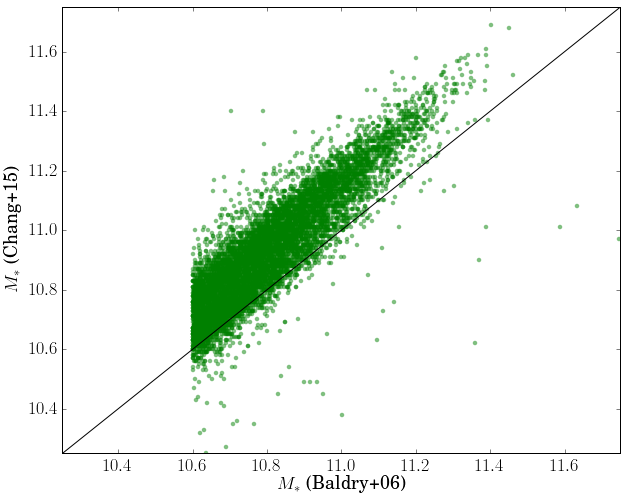

In [8]:
plt.scatter(spirals['LOGMSTAR_BALDRY06'],spirals['lmass50_all'],color='g',marker='o',lw=0,s=20,alpha=0.5)
plt.axis([10.25,11.75,10.25,11.75])
plt.plot([10,12],[10,12],'k-')

plt.xlabel('$M_*$ (Baldry+06)')
plt.ylabel('$M_*$ (Chang+15)')

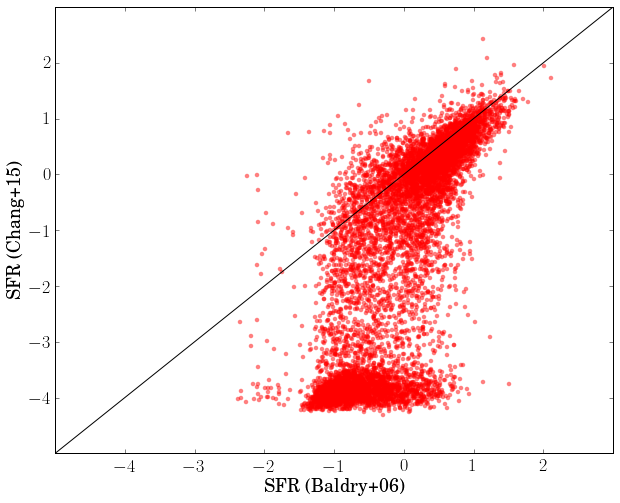

In [9]:
plt.scatter(spirals['sfr_total_avg'],spirals['lsfr50_all'],color='r',marker='o',lw=0,s=20,alpha=0.5)
plt.axis([-5,3,-5,3])
plt.plot([-5,3],[-5,3],'k-')

plt.xlabel('SFR (Baldry+06)')
plt.ylabel('SFR (Chang+15)')

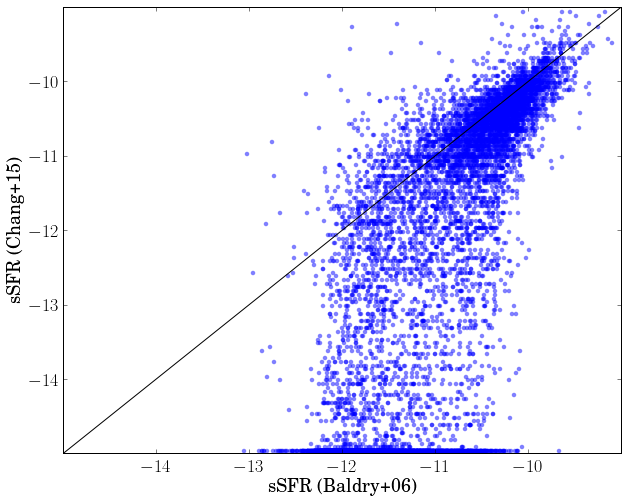

In [10]:
plt.scatter(spirals['ssfr_total_avg'],spirals['lssfr50_all'],color='b',marker='o',lw=0,s=20,alpha=0.5)
plt.axis([-15,-9,-15,-9])
plt.plot([-15,-9],[-15,-9],'k-')

plt.xlabel('sSFR (Baldry+06)')
plt.ylabel('sSFR (Chang+15)')

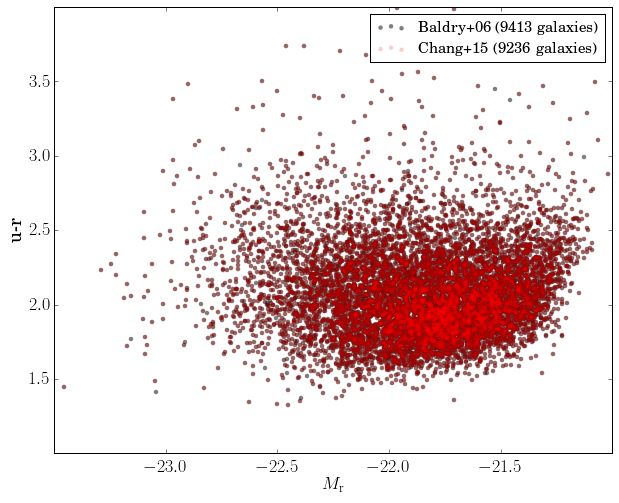

In [11]:
# Are we preferentially losing any galaxies in colour-magnitude space?

plt.scatter(spirals_full['PETROMAG_MR'],spirals_full['PETROMAG_MU']-spirals_full['PETROMAG_MR'],
            color='k',marker='o',lw=0,s=20,alpha=0.5,label='Baldry+06 ({} galaxies)'.format(len(spirals_full)))

plt.scatter(spirals['PETROMAG_MR'],spirals['PETROMAG_MU']-spirals['PETROMAG_MR'],
            color='r',marker='o',lw=0,s=20,alpha=0.2,label='Chang+15 ({} galaxies)'.format(len(spirals)))

plt.axis([-23.5,-21,1,4])
plt.legend(fontsize=15)

plt.xlabel('$M_\mathrm{r}$')
plt.ylabel('u-r')

In [12]:
from scipy.stats import binned_statistic

def bin_by_column(column, nbins, fixedcount=True):
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins

In [13]:
# Plot SFR and mass relations for the new catalogues:
from scipy.stats import binned_statistic
import scipy.stats.distributions as dist

def get_arm_fraction(column,bins,m):
    
    N_b = len(np.unique(bins))
    fractions = np.zeros(N_b)
    upper_fracs = np.zeros(N_b)
    lower_fracs = np.zeros(N_b)
    
    for n,b in enumerate(np.unique(bins)):
        
        bin_col = column[bins == b]
        bin_m = np.sum(bin_col == m)
        bin_tot = len(bin_col)
        
        f_low,f_high = get_fractional_errors(bin_m,bin_tot)
        fractions[n] = bin_m/bin_tot
        lower_fracs[n] = f_low
        upper_fracs[n] = f_high
    
    fractions_table = Table(np.array([lower_fracs,fractions,upper_fracs]).T
                            ,names=('low_f','f','high_f'))
    
    return fractions_table


def get_fractional_errors(k,n,c=0.683):
    
    p_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    
    return p_lower,p_upper


def bin_by_column(column, nbins, fixedcount=True):
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins

In [14]:
def histograms(column,assignments,axarr,bins,
               reference_column=None,linestyle='solid',linewidth=3,ref_col='k',
               mean_lines=False,ylims=None):
    
    labels = questions['t11_arms_number']['answerlabels']
    
    for m,ax in enumerate(axarr):
        
        column_m = column[assignments == m]
        
        if reference_column != None:
            _ = ax.hist(reference_column,bins,histtype='stepfilled',alpha=0.3,
                        color=ref_col,normed=True)
        
        if column != None:
            _ = ax.hist(column_m,bins,histtype='step',linestyle=linestyle,
                        color=colors_long[m],linewidth=linewidth,normed=True)
            
        if mean_lines == True:
            #yl = plt.gca().get_ylim()
            ax.vlines(np.mean(column_m),ylims[0],ylims[1],color=colors_long[m],
                       linewidth=2,linestyle='dashed')
            ax.vlines(np.mean(column_m)-np.std(column_m),ylims[0],ylims[1],color=colors_long[m],
                       linewidth=2,linestyle='dashed')
            ax.vlines(np.mean(column_m)+np.std(column_m),ylims[0],ylims[1],color=colors_long[m],
                       linewidth=2,linestyle='dashed')
        
        ax.set_ylabel('$f_\mathrm{normalised}$')
        ax.text(0.975,0.9,'m={} ({} galaxies)'.format(labels[m],len(column_m))
                ,transform=ax.transAxes,ha='right',va='top')
        
    return fig,axarr


def lines(column,assignments,axarr,nbins=20):
    
    labels = questions['t11_arms_number']['answerlabels']
    
    z,bins = bin_by_column(column,nbins)

    for m,ax in enumerate(axarr):
        
        column_m = column[assignments == m]
        
        fracs = get_arm_fraction(assignments,bins,m)
        axarr[m].plot(z,fracs['f'],linewidth=2,linestyle='solid',color=colors_long[m])
        axarr[m].fill_between(z,fracs['low_f'],fracs['high_f'],color=colors_long[m],alpha=0.5)

        ax.set_ylabel('$f_\mathrm{{m=' + '{}'.format(labels[m]) + '}}$')
        
    return fig,axarr

/home/ppxrh/anaconda3/lib/python3.4/site-packages/numpy/ma/core.py:3671: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  check = ndarray.__ne__(self.filled(0), other)


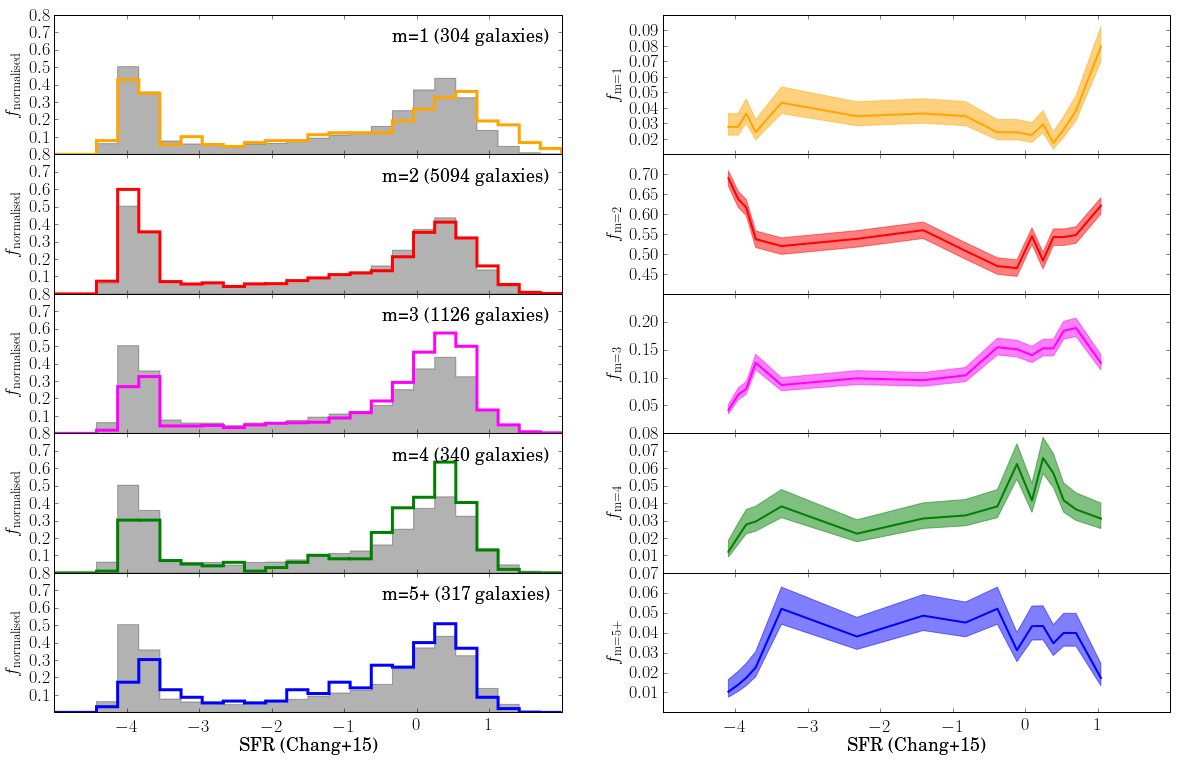

In [15]:
fig,axarr = plt.subplots(5,2,figsize=(20,12.5),sharex=True,sharey=False)
plt.subplots_adjust(hspace=0,wspace=0.2)

column = spirals['lsfr50_all']

axarr1 = axarr[:,0]
axarr2 = axarr[:,1]

for ax in axarr[-1]:
    ax.set_xlabel('SFR (Chang+15)')

histograms(column,arm_assignments,axarr1,np.linspace(-5,2,25),
           reference_column=column)

lines(column,arm_assignments,axarr2,nbins=16)

axarr = axarr.ravel()

for ax in axarr1:
    ax.set_ylim(0,0.8)

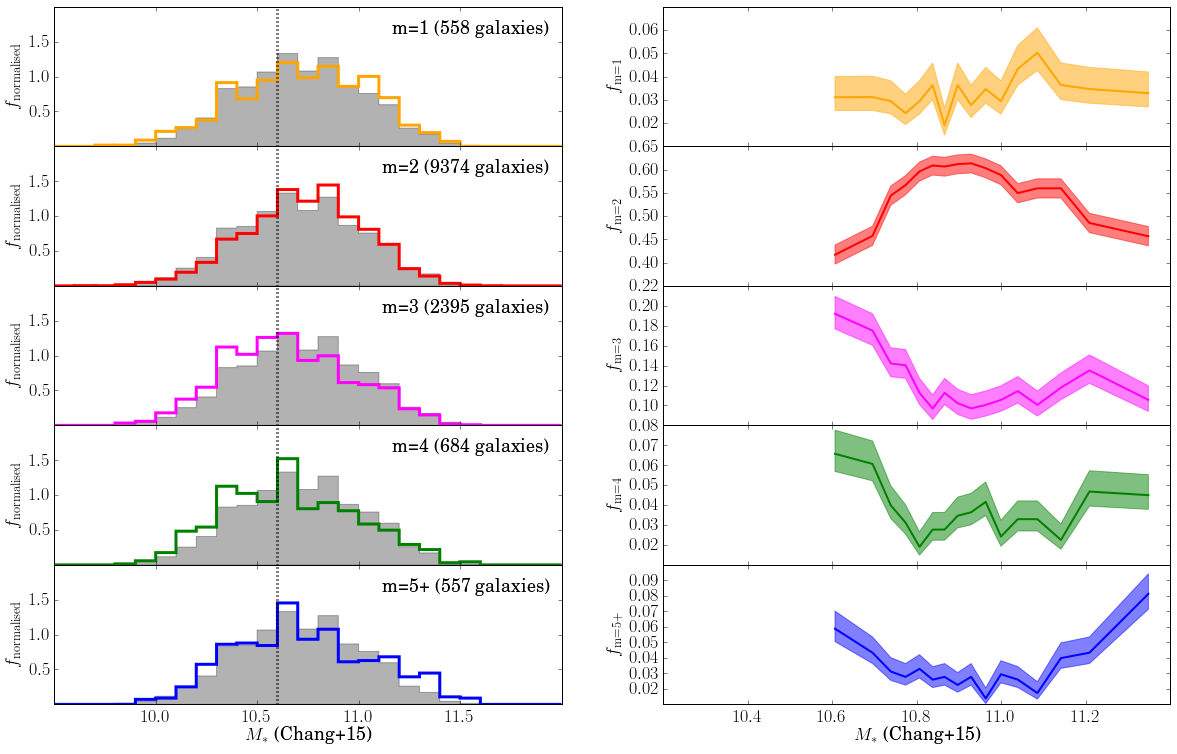

In [16]:
fig,axarr = plt.subplots(5,2,figsize=(20,12.5),sharex=False,sharey=False)
plt.subplots_adjust(hspace=0,wspace=0.2)

column = spirals['lmass50_all']
column_vl = spirals_vl['lmass50_all']

axarr1 = axarr[:,0]
axarr2 = axarr[:,1]

for ax in axarr[-1]:
    ax.set_xlabel('$M_*$ (Chang+15)')

histograms(column_vl,arm_assignments_vl,axarr1,np.linspace(9.5,12,26),
           reference_column=column_vl)

lines(column,arm_assignments,axarr2,nbins=16)

axarr = axarr.ravel()

for ax in axarr1:
    ax.set_ylim(0,2)
    ax.vlines(10.6,0,2,color='k',linestyle='dotted',lw=3)
    
for ax in axarr2:
    ax.set_xlim(10.2,11.4)
    ax.set_xticks(np.linspace(10.4,11.2,5))

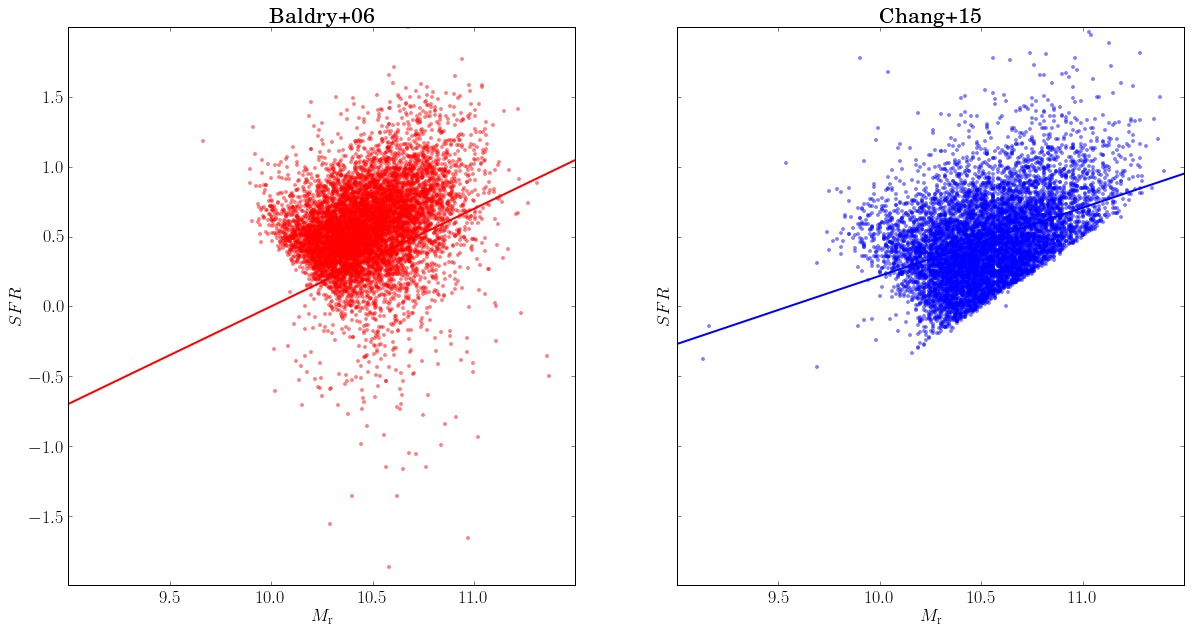

In [17]:
# mass sfr relations for each of the methods:
from scipy.optimize import curve_fit

def linear(x,k,c):
    return k*x + c

#sf = spirals_vl['lssfr50_all'] > -0.5
sf = spirals_vl['lssfr50_all'] > -10.5

baldry_fit,_ = curve_fit(linear,
                         spirals_vl['LOGMSTAR_BALDRY06'][sf],
                         spirals_vl['sfr_total_avg'][sf],p0=[0.7,-7])

chang_fit,_ = curve_fit(linear,
                        spirals_vl['lmass50_all'][sf],
                        spirals_vl['lsfr50_all'][sf],p0=[0.7,-7])

fig,axarr = plt.subplots(1,2,figsize=(20,10),sharex=True,sharey=True)


axarr[0].scatter(spirals_vl['LOGMSTAR_BALDRY06'][sf],spirals_vl['sfr_total_avg'][sf]
                 ,marker='o',s=15,color='r',lw=0,alpha=0.5)
axarr[1].scatter(spirals_vl['lmass50_all'][sf],spirals_vl['lsfr50_all'][sf]
                 ,marker='o',s=15,color='b',lw=0,alpha=0.5)

xg = np.array([9,11.5])

axarr[0].plot(xg,linear(xg,*baldry_fit),'r-',lw=2)
axarr[1].plot(xg,linear(xg,*chang_fit),'b-',lw=2)

plt.axis([9,11.5,-2,2])

for ax in axarr:
    ax.set_xlabel('$M_{\mathrm{r}}$')
    ax.set_ylabel('$SFR$')
    
axarr[0].set_title('Baldry+06')
axarr[1].set_title('Chang+15')

In [18]:
def display_image(url_name,crop_in=100):
    # Get the url name:
    urllib.request.urlretrieve(url_name,"image.jpg")
    # Open -> crop -> display -> remove the image.
    im=Image.open("image.jpg")
    l=424 # Image size
    im=im.crop((crop_in,crop_in,l-crop_in,l-crop_in))
    plt.imshow(im)
    os.remove("image.jpg")
    plt.xticks([])
    plt.yticks([])
    return None

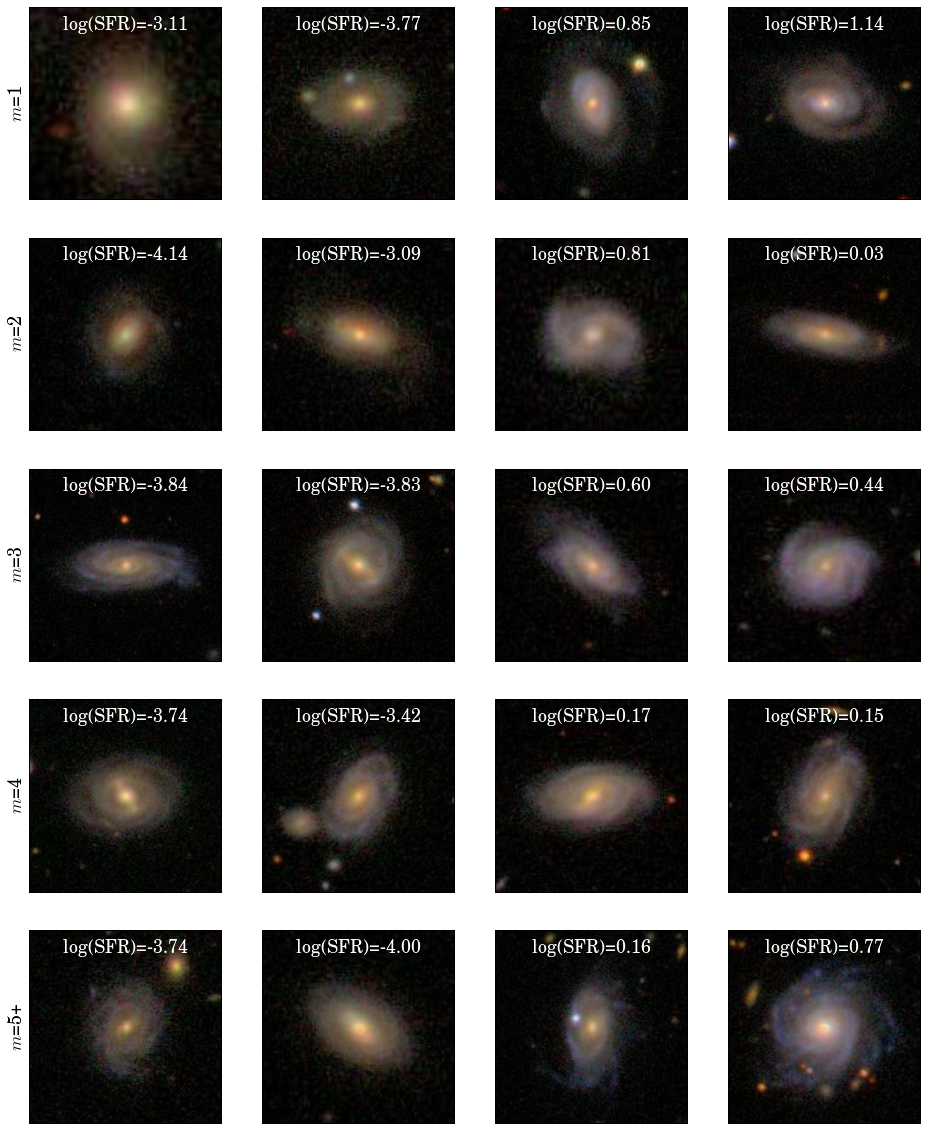

In [19]:
# Get some comparison images?

labels = questions['t11_arms_number']['answerlabels']

fig,axarr = plt.subplots(5,4,figsize=(16,20))

low_sf = spirals['lsfr50_all'] < -3
high_sf = spirals['lsfr50_all'] > 0

for j,sf in enumerate([low_sf,high_sf]):
    
    sf_selected_spirals = spirals[sf]
    sf_selected_arms = arm_assignments[sf]
    
    for m in range(5):
        
        m_spirals = sf_selected_spirals[sf_selected_arms == m]
        random.shuffle(m_spirals)
        
        _,v = np.unique(m_spirals['dr7objid_1'],return_index=True)
        m_spirals = m_spirals[v] # Remove duplicates?
        
        for i in [0,1]:
            
            url = m_spirals['jpeg_url'][i]
            sfr = m_spirals['lsfr50_all'][i]
            plt.sca(axarr[m,2*j+i])
            ax = axarr[m,2*j+i]
            display_image(url)
            plt.text(0.5,0.95,'log(SFR)={0:.2f}'.format(sfr),
                     ha='center',va='top',transform=ax.transAxes,color='w')
            
for i,ax in enumerate(axarr[:,0]):
    ax.set_ylabel('$m$={}'.format(labels[i]))